In [62]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import diffprivlib.models as dp
from sklearn.linear_model import LogisticRegression
from torch import nn, optim
from opacus import PrivacyEngine
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader


# Importing train, test split library
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# efficacy metrics from sklearn
from sklearn import metrics


#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# bias
# holisticai imports
import holisticai
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.bias.mitigation.postprocessing import CalibratedEqualizedOdds, RejectOptionClassification

## Load Training and Testing Data

In [5]:
# # Load the data
# X_train = pd.read_csv('../../data/X_train.csv',index_col=0).drop(['id'],axis=1)
# y_train = pd.read_csv('../../data/y_train.csv',index_col=0)
# X_test = pd.read_csv('../../data/X_test.csv',index_col=0).drop(['id'],axis=1)
# y_test = pd.read_csv('../../data/y_test.csv',index_col=0)

In [6]:
baseline__df = pd.read_csv("../../data/data_baseline.csv",index_col=0)
baseline__df.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_desc,two_year_recid,time_in_custody_in_days,time_in_jail_in_days,African-American_race,Asian_race,Hispanic_race,Native American_race,Other_race,Felony_c_charge_degree,High_score_text,Low_score_text,High_v_score_text
id,,,,,,,,,,,,,,,,,,,
1,1,69,0,0,0,0,0.282331,0,7.0,0.0,0,0,0,0,1,1,0,1,0
3,1,34,0,0,0,0,0.568689,1,10.0,10.0,1,0,0,0,0,1,0,1,0
4,1,24,0,0,1,4,0.600344,1,0.0,1.0,1,0,0,0,0,1,0,1,0
5,1,23,0,1,0,1,0.368006,0,0.0,0.0,1,0,0,0,0,1,1,0,0
6,1,43,0,0,0,2,0.439192,0,0.0,0.0,0,0,0,0,1,1,0,1,0


In [7]:
baseline__df.columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_desc', 'two_year_recid',
       'time_in_custody_in_days', 'time_in_jail_in_days',
       'African-American_race', 'Asian_race', 'Hispanic_race',
       'Native American_race', 'Other_race', 'Felony_c_charge_degree',
       'High_score_text', 'Low_score_text', 'High_v_score_text'],
      dtype='object')

In [8]:
baseline__df = baseline__df.drop(['Asian_race','Hispanic_race','Other_race','High_score_text','High_v_score_text','Low_score_text','Native American_race'],axis=1)

In [9]:
baseline__df.columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_desc', 'two_year_recid',
       'time_in_custody_in_days', 'time_in_jail_in_days',
       'African-American_race', 'Felony_c_charge_degree'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    baseline__df.drop(["two_year_recid"], axis=1),
    baseline__df["two_year_recid"],
    test_size=0.2,
    random_state=1000,
    stratify=baseline__df["two_year_recid"],
)

In [11]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

## Transform Data for the Model

In [12]:
group_a_train = X_train["African-American_race"] == 1
group_b_train = X_train["African-American_race"] == 0
data_train = [X_train, y_train, group_a_train, group_b_train]


group_a_test = X_test["African-American_race"] == 1
group_b_test = X_test["African-American_race"] == 0
data_test = [X_test, y_test, group_a_test, group_b_test]	

In [13]:
# group_a_train = X_train["sex"] == 1
# group_b_train = X_train["sex"] == 0
# data_train = [X_train, y_train, group_a_train, group_b_train]


# group_a_test = X_test["sex"] == 1
# group_b_test = X_test["sex"] == 0
# data_test = [X_test, y_test, group_a_test, group_b_test]


Defining the functions to calcluate the perfomace metrics

In [14]:

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Check the shapes of the scaled data
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((5748, 11), (1437, 11), (5748, 1), (1437, 1))

Checking Prediction distribution in training and test data

In [17]:
test_df = X_test.copy()
test_df['y_test'] = y_test

In [18]:
test_proportion = test_df[['African-American_race','y_test']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_test']['sum']/test_proportion['y_test']['count']
test_proportion

y_test       prop_of_recidivism
                         sum count                   
African-American_race                                
0                        269   707           0.380481
1                        378   730           0.517808

### 1. Baseline Logistic Regression Model

In [19]:
baseline_lr = LogisticRegression(solver="lbfgs", max_iter=1000)
baseline_lr.fit(X_train_scaled, y_train)

/Users/keshvigupta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [20]:
y_pred = baseline_lr.predict(X_test_scaled)
y_proba = baseline_lr.predict_proba(X_test_scaled)
y_score = y_proba[:,1]
y_true = y_test

#adding to the dataframe for analysis purpose
test_df['y_pred_lrb'] = y_pred
test_df['y_score_lrb'] = y_score

Model Performance

In [21]:
# Baseline efficacy
metrics_dataframe(y_pred, y_true)

,Value
Metric,
Accuracy,0.698678
Balanced accuracy,0.689859
Precision,0.689716
Recall,0.601236
F1-Score,0.642444


Fairness Performance

In [22]:
fairness_metrics = classification_bias_metrics(group_a_test, group_b_test, y_pred, y_true, metric_type='both')
fairness_metrics.iloc[6]

Value        0.123106
Reference    0.000000
Name: False Positive Rate Difference, dtype: float64

In [23]:
test_proportion = test_df[['African-American_race','y_pred_lrb']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_pred_lrb']['sum']/test_proportion['y_pred_lrb']['count']
test_proportion

y_pred_lrb       prop_of_recidivism
                             sum count                   
African-American_race                                    
0                            198   707           0.280057
1                            366   730           0.501370

Model exacerbated the bias

In [24]:
list(X_train.columns)

['sex',
 'age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'c_charge_desc',
 'time_in_custody_in_days',
 'time_in_jail_in_days',
 'African-American_race',
 'Felony_c_charge_degree']

In [25]:
feature_imp_baseline = pd.DataFrame({'Varibale' : list(X_train.columns), 'coeff' : list(baseline_lr.coef_[0])})
feature_imp_baseline.sort_values(by='coeff',ascending=False)

,Varibale,coeff
6,c_charge_desc,0.725889
5,priors_count,0.624495
8,time_in_jail_in_days,0.189535
4,juv_other_count,0.133150
7,time_in_custody_in_days,0.114599
2,juv_fel_count,0.102986
0,sex,0.102928
9,African-American_race,0.028342
3,juv_misd_count,0.004700
10,Felony_c_charge_degree,-0.131001


<AxesSubplot:xlabel='y_score_lrb', ylabel='Density'>

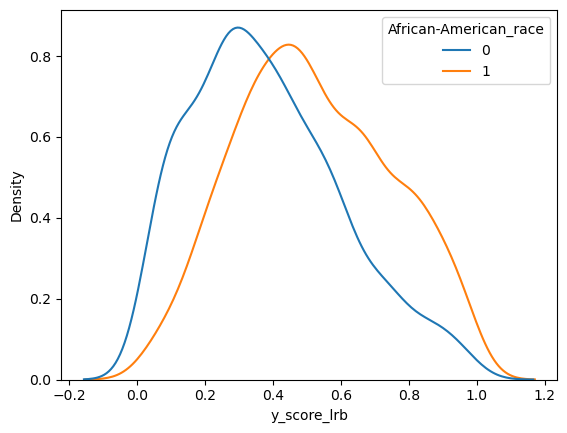

In [26]:
sns.kdeplot(data=test_df, x= 'y_score_lrb',hue='African-American_race')

### 2. Differentially Private Logistic Regression Model


epsilon (ε) represents the maximum acceptable difference in the model's output when the dataset is modified by adding or removing a single data point. 
Intuition: 
When epsilon is provided to a logistic regression model, it guides the model to learn a representation of the data that is less sensitive to individual changes.

By introducing epsilon, the logistic regression model limits the amount of information that can be inferred about any single individual. This is achieved by adding noise to the model's parameters or predictions, making it difficult for an adversary to discern the impact of any single data point.

This is equivalent to learning Fair Representation in terms of Fairness, whereas individual's association witht the outcome is obfuscated, and therefore we expect to see fairer model just by introducing the privacy budget

To-do : *write a loop plot*

In [27]:
dp_clf = dp.LogisticRegression(random_state=0,epsilon=10)
dp_clf.fit(X_train_scaled, y_train)

/Users/keshvigupta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/keshvigupta/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


LogisticRegression(accountant=BudgetAccountant(spent_budget=[(10, 0)]),
                   data_norm=30.38800759702258, epsilon=10, random_state=0)

In [28]:
#predicting
y_pred_dp = dp_clf.predict(X_test_scaled)
y_proba_dp = dp_clf.predict_proba(X_test_scaled)
y_score_dp = y_proba_dp[:,1]

Private Model Performance

In [29]:
# Baseline efficacy
metrics_dataframe(y_pred_dp, y_true)

,Value
Metric,
Accuracy,0.697982
Balanced accuracy,0.690205
Precision,0.683938
Recall,0.612056
F1-Score,0.646003


Private Model Fairness Performance

In [30]:
fairness_metrics_dp = classification_bias_metrics(group_a_test, group_b_test, y_pred_dp, y_true, metric_type='both')
fairness_metrics_dp.iloc[6]

Value        0.125337
Reference    0.000000
Name: False Positive Rate Difference, dtype: float64

Private Model Fairness Interpretation

In [31]:
feature_imp_dp = pd.DataFrame({'Varibale' : list(X_train.columns), 'coeff' : list(dp_clf.coef_[0])})
feature_imp_dp.sort_values(by='coeff',ascending=False)

,Varibale,coeff
6,c_charge_desc,0.701089
5,priors_count,0.691110
8,time_in_jail_in_days,0.255380
4,juv_other_count,0.124578
2,juv_fel_count,0.074533
7,time_in_custody_in_days,0.043191
0,sex,0.039016
9,African-American_race,0.001030
3,juv_misd_count,-0.022961
10,Felony_c_charge_degree,-0.103773


In [32]:
print("Privacy Measure : ", dp_clf.epsilon)
print("Fairness measure: ", fairness_metrics_dp.iloc[6][0])

Privacy Measure :  10
Fairness measure:  0.1253372768783728


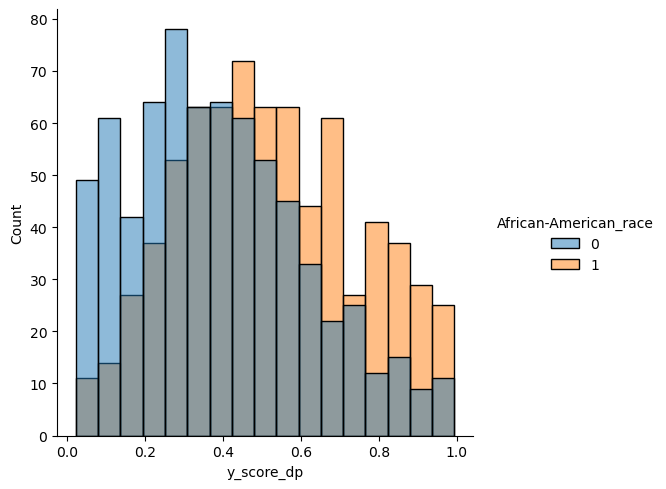

In [33]:
test_df['y_pred_dp'] = y_pred_dp
test_df['y_score_dp'] = y_score_dp
sns.displot(data=test_df, x= 'y_score_dp',hue= 'African-American_race')

In [34]:
test_proportion = test_df[['African-American_race','y_pred_dp']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_pred_dp']['sum']/test_proportion['y_pred_dp']['count']
test_proportion

y_pred_dp       prop_of_recidivism
                            sum count                   
African-American_race                                   
0                           206   707           0.291372
1                           373   730           0.510959

<h3> Implementing Fairness

1. Caliberated Equalized Odds

In [35]:
# initialize object
ceo = CalibratedEqualizedOdds(cost_constraint="fpr")

In [36]:
# predict train set
y_pred_train_dp = dp_clf.predict(X_train_scaled)
y_proba_train_dp = dp_clf.predict_proba(X_train_scaled)

In [37]:
# fit it
ceo.fit(y_train, y_proba_train_dp, group_a_train, group_b_train)

In [38]:
# transform it
d = ceo.transform(y_test, y_proba_dp, group_a_test, group_b_test, 0.3)
# new predictions
y_pred_ceo = d['y_pred']
y_score_ceo = d['y_score']

#adding for future analysis
test_df['y_pred_ceo'] = y_pred_ceo
test_df['y_score_ceo'] = y_score_ceo

In [39]:
y_pred_ceo

array([0, 1, 1, ..., 1, 1, 1])

Fair Model Perormance : CEO

In [40]:
# efficacy
metrics_dataframe(y_pred_ceo, y_test)

,Value
Metric,
Accuracy,0.514962
Balanced accuracy,0.555783
Precision,0.480769
Recall,0.965997
F1-Score,0.642013


Fair Model Fairness Performance :  CEO

In [41]:
fairness_metrics_ceo = classification_bias_metrics(group_a_test, group_b_test, y_pred_ceo, y_test, metric_type='both')
print("Fairness metric : ", fairness_metrics_ceo.iloc[6][0])

Fairness metric :  -0.3267045454545454


Fairness got worse

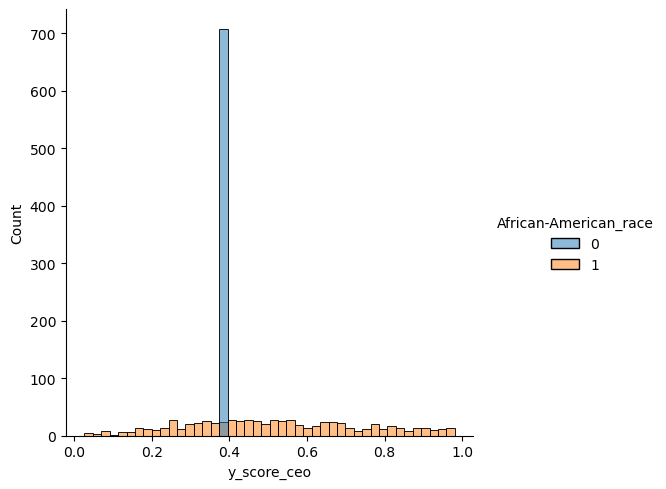

In [42]:
sns.displot(data=test_df, x= 'y_score_ceo',hue= 'African-American_race')

Pros : 
Optimizes for FPR
cons : 
GIves all the predicstions the same probability, so while classifying, all people go to just one group. Thereofre not desirable

In [43]:
test_proportion = test_df[['African-American_race','y_pred_ceo']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_pred_ceo']['sum']/test_proportion['y_pred_ceo']['count']
test_proportion

y_pred_ceo       prop_of_recidivism
                             sum count                   
African-American_race                                    
0                            707   707           1.000000
1                            593   730           0.812329

<h3> Reject Option Classification

Pros : 
this approach is applicable to different fairness definitions as well. Fairness Definition agnostic.
More practical as it works on benefit of doubt model, and does not make 'confidently wrong' predictions
Cons : 
Does not optimize for FPRD
Solution?
Optimize for 'Statistical Parity Difference'? 
Statistical parity difference measures the difference in the positive prediction rate/Precision between the privileged and unprivileged groups. so if we set low and high threshold smartly, it will optinize for FRPD by maximizing the precision. 
Can't use AOD and EOD because they optimize for Recall. not what we want.

In [44]:
#changing the lables since ROC considers 1 as fav label, and optimizes for it
y_train_flipped = y_train.copy()
y_train_flipped['two_year_recid'] = np.where(y_train_flipped['two_year_recid'] == 1,0,1)

y_test_flipped = y_test.copy()
y_test_flipped['two_year_recid'] = np.where(y_test_flipped['two_year_recid'] == 1,0,1)

fitting new lr model with swapped labels

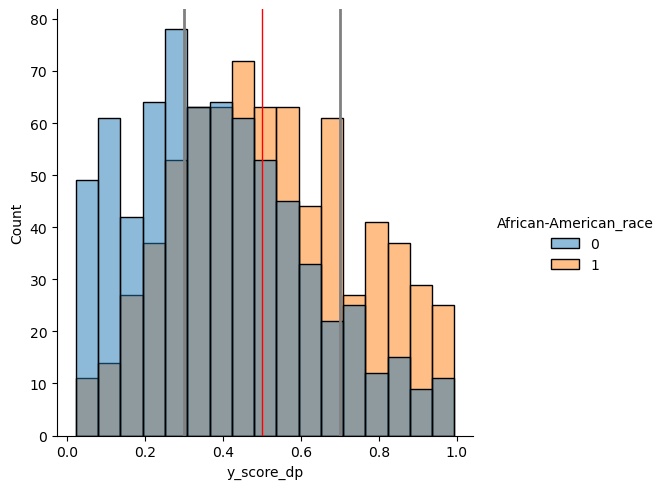

In [45]:
#investigating the most uncertain region
sns.displot(data=test_df, x= 'y_score_dp',hue= 'African-American_race')
# Add dotted lines
plt.axvline(x=0.3, color='gray', linestyle='-', linewidth=2)
plt.axvline(x=0.7, color='gray', linestyle='-', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='-', linewidth=1)

In [46]:
# initialize
roc = RejectOptionClassification(metric_name="Statistical parity difference",low_class_thresh=0.3, high_class_thresh=0.7)
# fit on train
roc.fit(y_train, y_proba_train_dp, group_a_train, group_b_train)
#transform test
d_roc = roc.transform(y_test, y_proba_dp, group_a_test, group_b_test)
# new predictions
y_pred_roc = d_roc['y_pred']

test_df['y_pred_roc'] = d_roc['y_pred']
test_df['y_score_roc'] = d_roc['y_score']

In [47]:
# efficacy
metrics_dataframe(y_pred_roc, y_test)

,Value
Metric,
Accuracy,0.636743
Balanced accuracy,0.604713
Precision,0.759336
Recall,0.282844
F1-Score,0.412162


In [48]:
# bias metrics
fairness_metrics_roc = classification_bias_metrics(group_a_test, group_b_test, y_pred_roc, y_test, metric_type='both')
fairness_metrics_roc.iloc[6][0]

0.06741645911166459

In [49]:
test_proportion = test_df[['African-American_race','y_pred_roc']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_pred_roc']['sum']/test_proportion['y_pred_roc']['count']
test_proportion

y_pred_roc       prop_of_recidivism
                             sum count                   
African-American_race                                    
0                             76   707           0.107496
1                            165   730           0.226027

In [50]:
test_df=test_df.reset_index()
test_df.to_csv("../../data/test_predictions.csv",index=False)

### Comparing Model Performance by Varying Privacy Budget and Fairness Metric

In [81]:
# Define the range of epsilon and boundary values using numpy
epsilons = np.arange(0.1, 10, 0.2)
# Define the range of low and high threshold values
low_thresholds = np.arange(0.45, 0.24, -0.05)
high_thresholds = np.arange(0.55, 0.76, 0.05)

# Generate pairs of low and high thresholds and round to 2 decimal places
boundaries = [(round(low, 2), round(high, 2)) for low, high in zip(low_thresholds, high_thresholds)]
results = []

In [82]:
epsilons

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1,
       5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7,
       7.9, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.3, 9.5, 9.7, 9.9])

In [83]:
boundaries

[(0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75)]

In [84]:
# Loop over epsilon and boundary values
for epsilon in epsilons:
    for low_thresh, high_thresh in boundaries:
        # Train the model with the current epsilon
        dp_clf = dp.LogisticRegression(random_state=0, epsilon=epsilon)
        dp_clf.fit(X_train_scaled, y_train)

        # Make predictions
        y_proba_dp = dp_clf.predict_proba(X_test_scaled)
        y_score_dp = y_proba_dp[:,1]

        # Initialize and fit the ROC
        roc = RejectOptionClassification(metric_name="Statistical parity difference", low_class_thresh=low_thresh, high_class_thresh=high_thresh)
        roc.fit(y_train, y_proba_train_dp, group_a_train, group_b_train)

        # Transform the test data
        d_roc = roc.transform(y_test, y_proba_dp, group_a_test, group_b_test)

        # Compute the fairness metrics
        fairness_metrics_roc = classification_bias_metrics(group_a_test, group_b_test, d_roc['y_pred'], y_test, metric_type='both')

        # Store the results
        results.append({
            'epsilon': epsilon,
            'low_class_thresh': low_thresh,
            'high_class_thresh': high_thresh,
            'accuracy': metrics.accuracy_score(y_test, d_roc['y_pred']),
            'precision': metrics.precision_score(y_test, d_roc['y_pred']),
            'fairness_metrics_roc': fairness_metrics_roc.iloc[6][0]
        })

In [85]:
# Convert the results to a DataFrame
df = pd.DataFrame(results)
display(df)

,epsilon,low_class_thresh,high_class_thresh,accuracy,precision,fairness_metrics_roc
0,0.1,0.45,0.55,0.538622,0.488439,-0.157469
1,0.1,0.40,0.60,0.538622,0.488304,-0.158585
2,0.1,0.35,0.65,0.537230,0.486647,-0.159701
3,0.1,0.30,0.70,0.536534,0.485714,-0.160816
4,0.1,0.25,0.75,0.537926,0.487023,-0.167614
...,...,...,...,...,...,...
245,9.9,0.45,0.55,0.688935,0.709205,0.102818
246,9.9,0.40,0.60,0.670146,0.724675,0.101300
247,9.9,0.35,0.65,0.656924,0.743671,0.107137
248,9.9,0.30,0.70,0.636743,0.759336,0.067416


In [86]:
df['accuracy'] = round(df['accuracy'],2)
df['precision'] = round(df['precision'],2)
df['fairness_metrics_roc'] = round(df['fairness_metrics_roc'],2)

In [87]:
df['fairness_metrics_roc_abs'] = abs(round(df['fairness_metrics_roc'],2))

In [90]:
df['fainress_band'] = np.where(abs(df['fairness_metrics_roc']) <= 0.07, 'fair', 'unfair')

In [92]:
df.to_csv("../../data/roc_results.csv", index=False)

In [104]:
dfs = {(low, high): df[(df['low_class_thresh'] == low) & (df['high_class_thresh'] == high)] 
       for low, high in df[['low_class_thresh', 'high_class_thresh']].drop_duplicates().values}

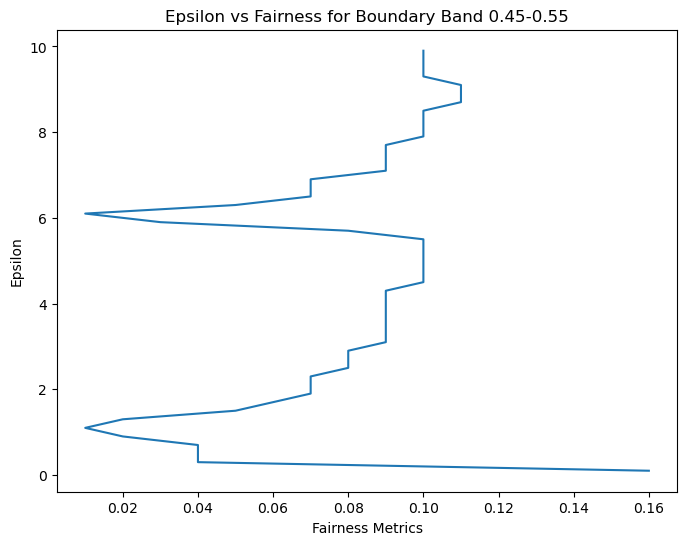

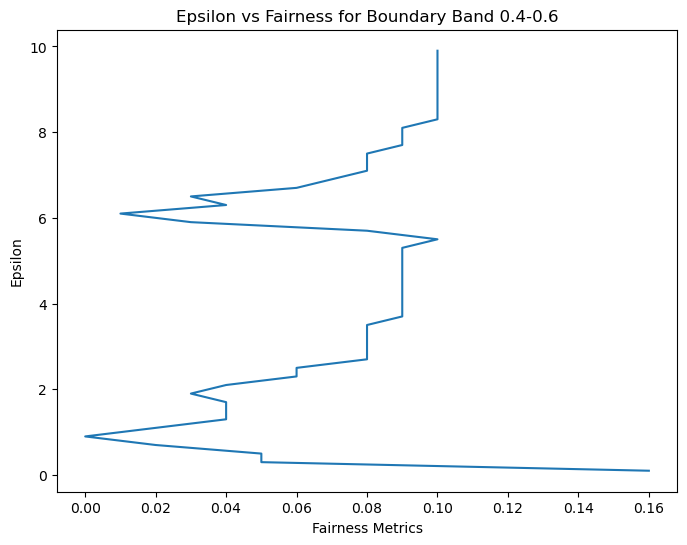

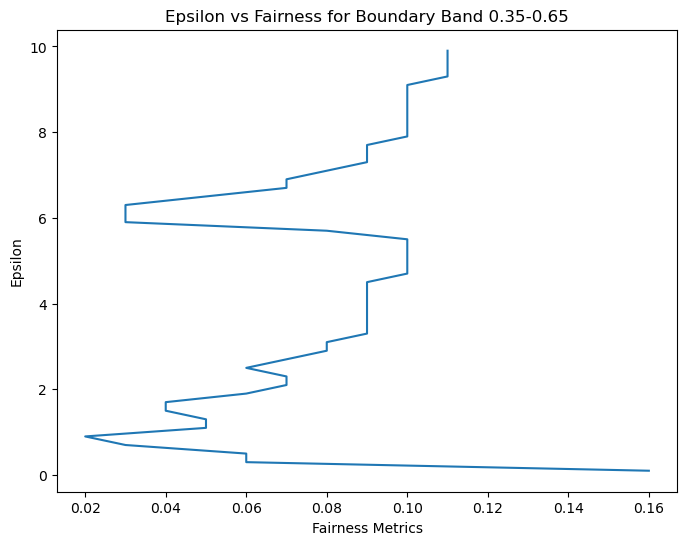

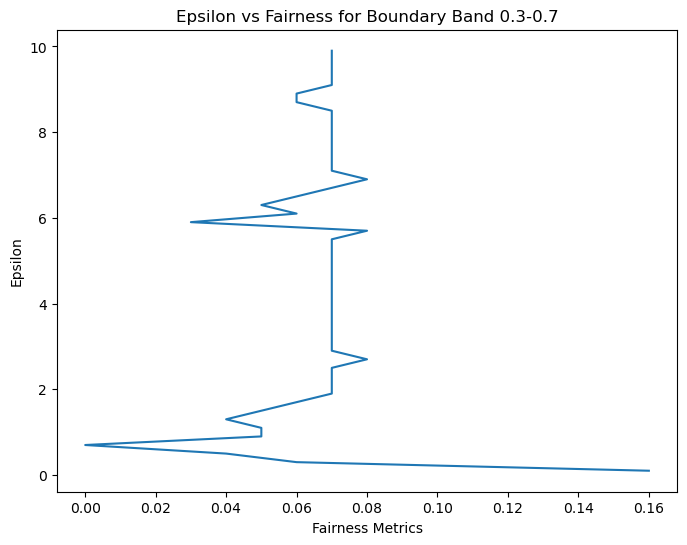

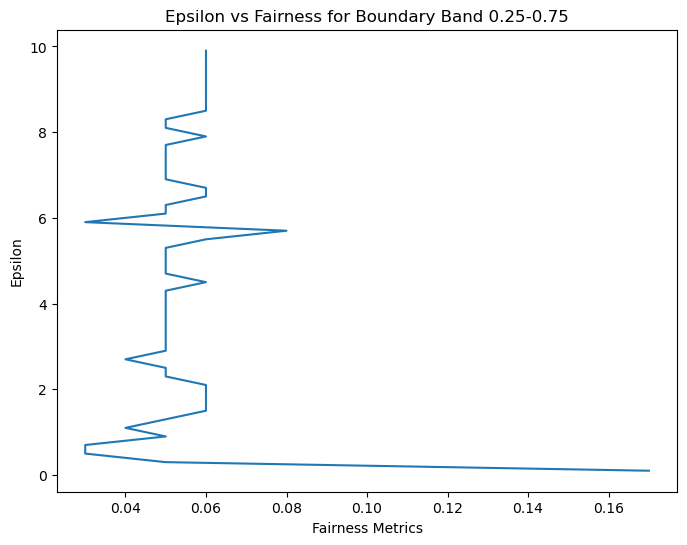

In [108]:
# Iterate over each boundary band DataFrame
for (low, high), band_df in dfs.items():
    plt.figure(figsize=(8, 6))
    plt.plot(band_df['fairness_metrics_roc_abs'], band_df['epsilon'])
    plt.xlabel('Fairness Metrics')
    plt.ylabel('Epsilon')
    plt.title(f'Epsilon vs Fairness for Boundary Band {low}-{high}')
    plt.show()

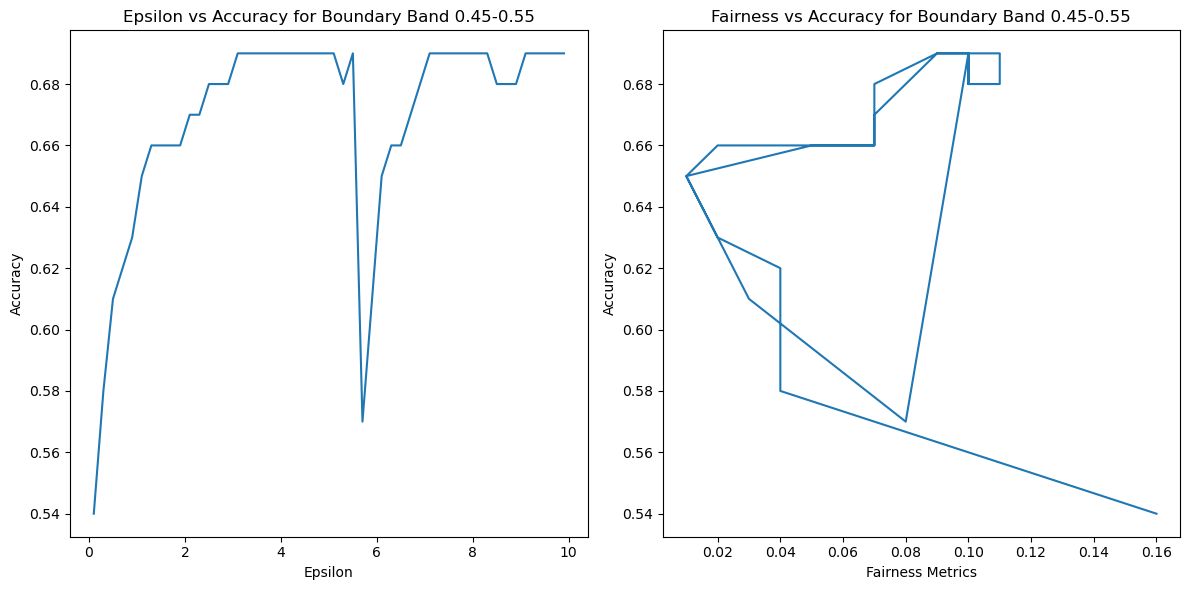

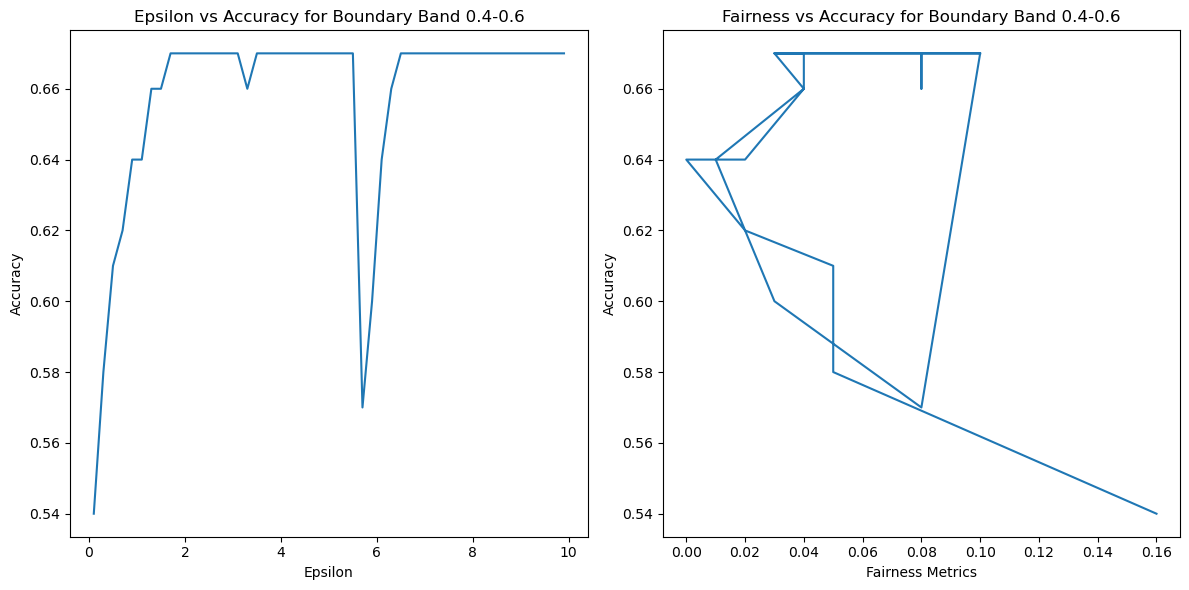

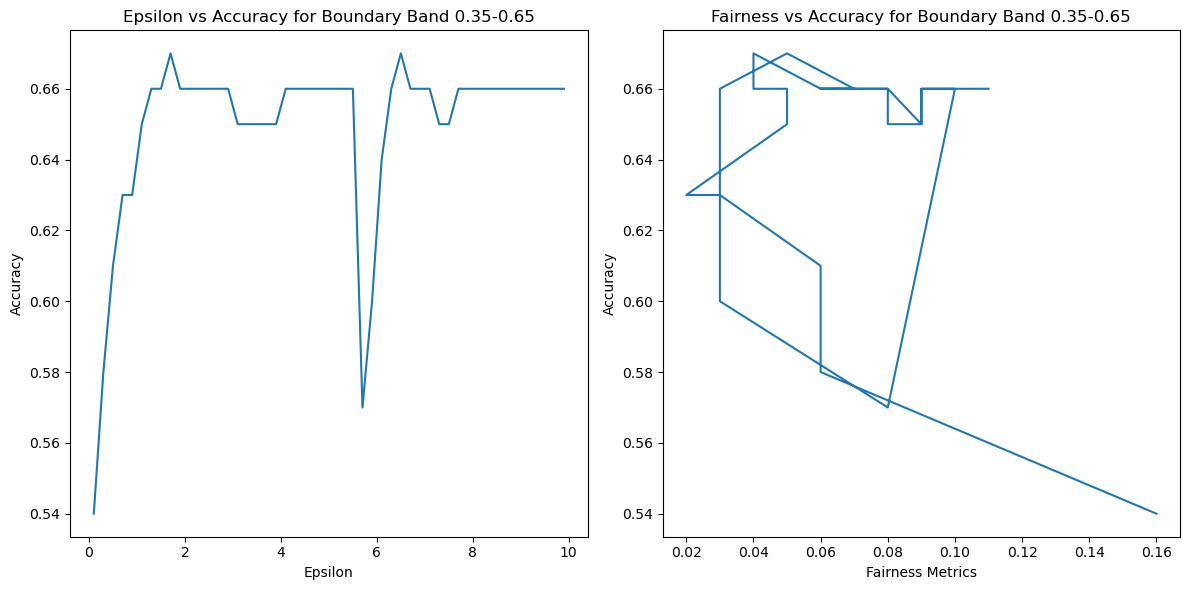

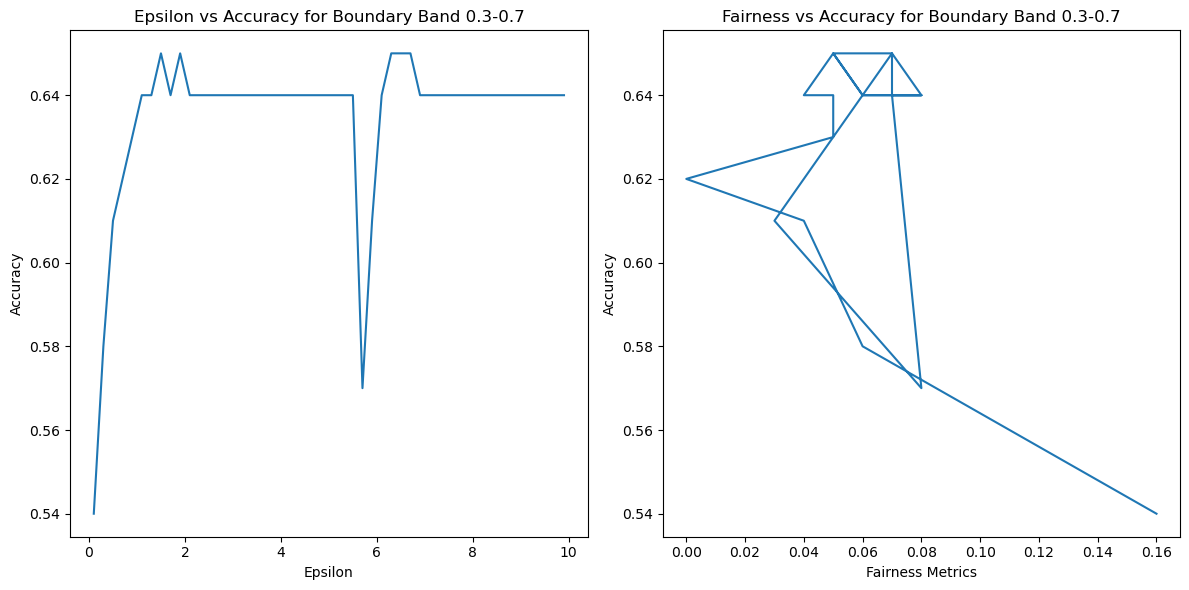

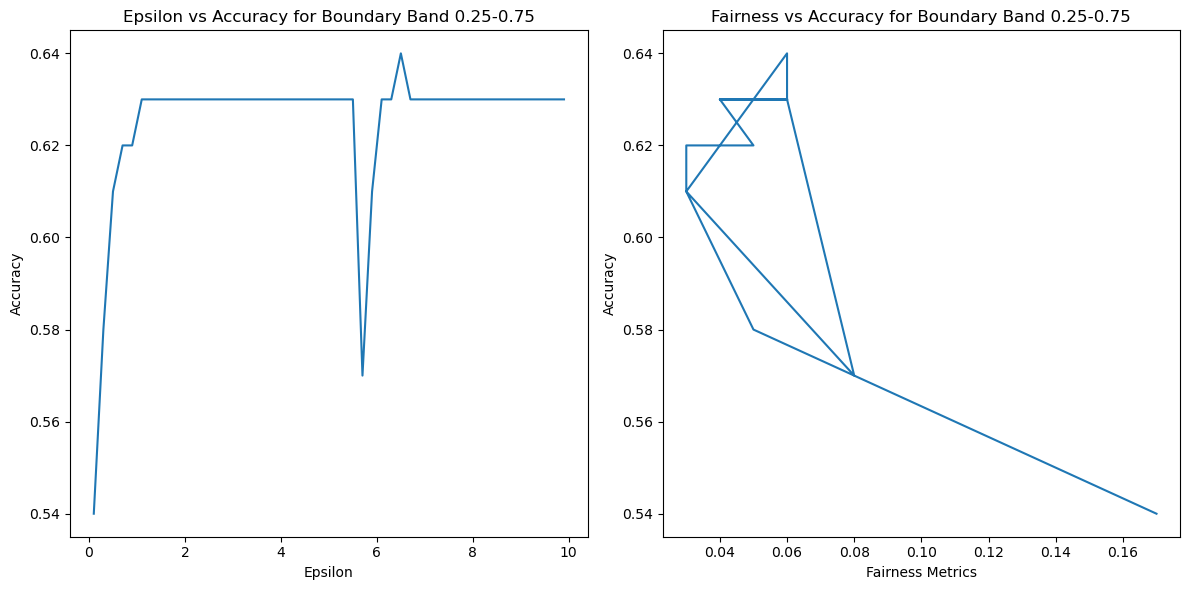

In [111]:
# Iterate over each boundary band DataFrame
for (low, high), band_df in dfs.items():
    # Create a new figure for each boundary band
    plt.figure(figsize=(12, 6))

    # Create a subplot for epsilon vs accuracy
    plt.subplot(1, 2, 1)
    plt.plot(band_df['epsilon'], band_df['accuracy'])
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(f'Epsilon vs Accuracy for Boundary Band {low}-{high}')

    # Create a subplot for fairness vs accuracy
    plt.subplot(1, 2, 2)
    plt.plot(band_df['fairness_metrics_roc_abs'], band_df['accuracy'])
    plt.xlabel('Fairness Metrics')
    plt.ylabel('Accuracy')
    plt.title(f'Fairness vs Accuracy for Boundary Band {low}-{high}')

    # Display the plots
    plt.tight_layout()
    plt.show()

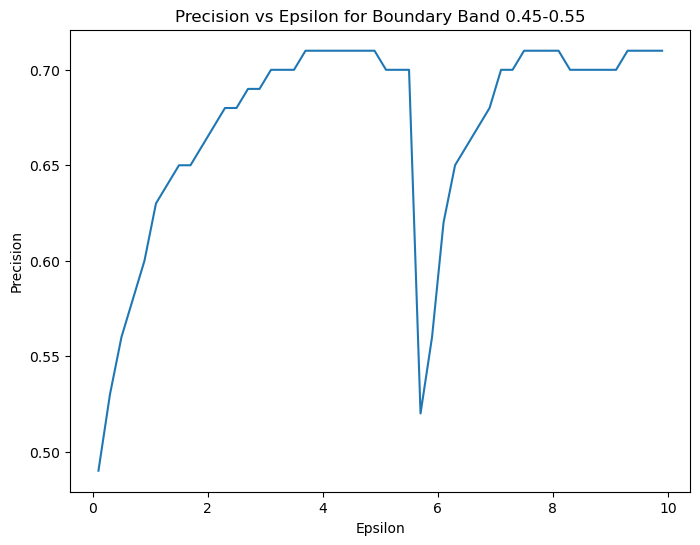

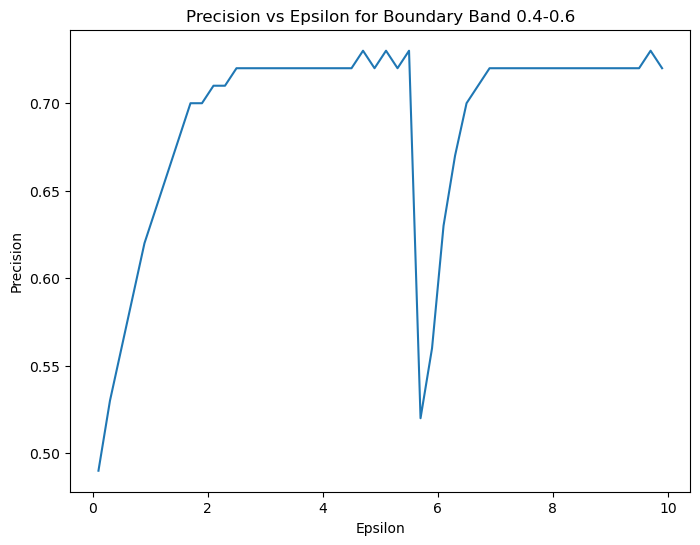

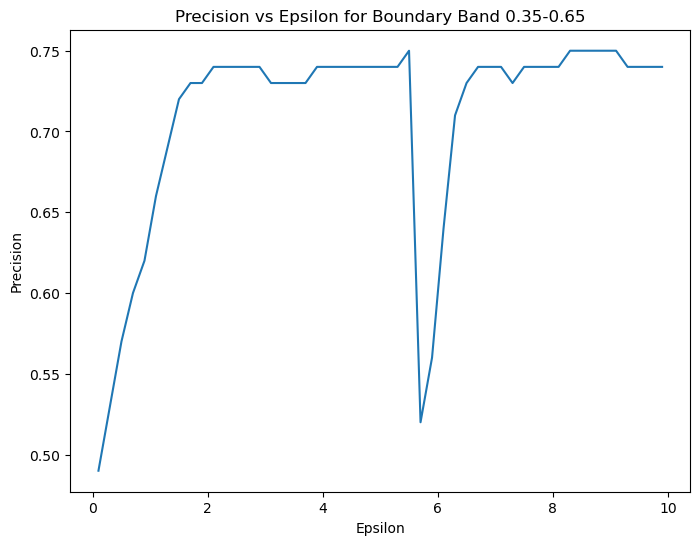

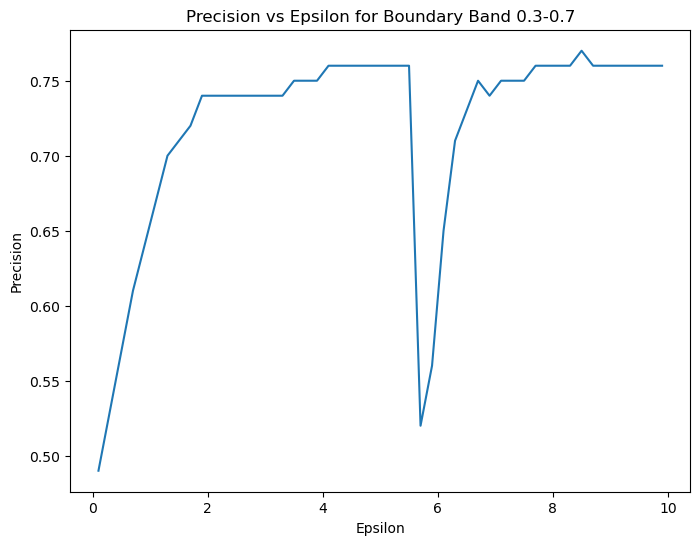

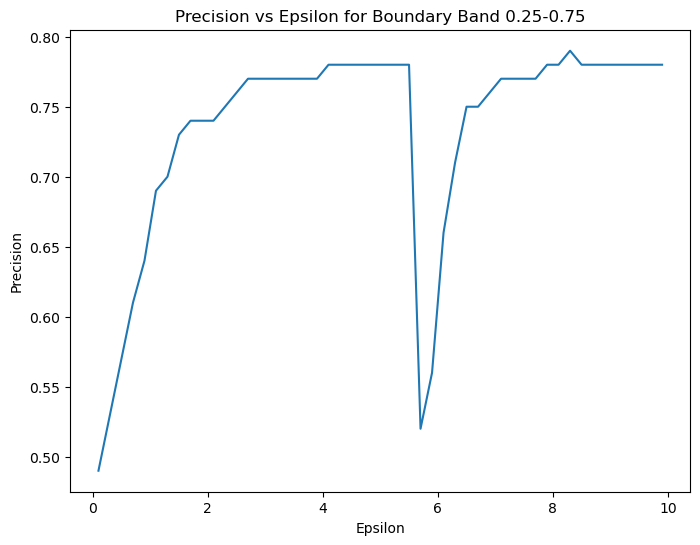

In [112]:
# Iterate over each boundary band DataFrame
for (low, high), band_df in dfs.items():
    plt.figure(figsize=(8, 6))
    plt.plot(band_df['epsilon'], band_df['precision'])
    plt.xlabel('Epsilon')
    plt.ylabel('Precision')
    plt.title(f'Precision vs Epsilon for Boundary Band {low}-{high}')
    plt.show()